In [1]:
import sim
import util
from IPython.display import clear_output
from models import GibbsSLDA, GibbsLDA

clear_output()

## Synthetic Data

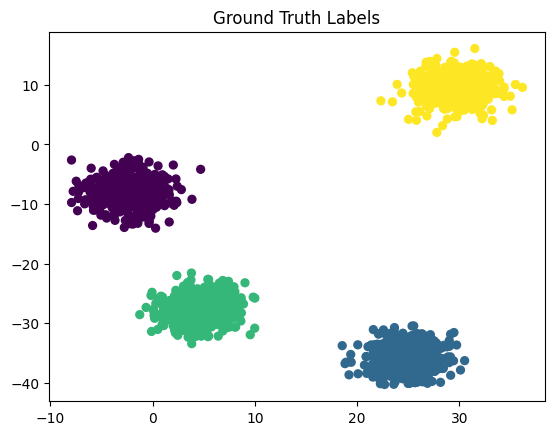

In [17]:
N_SAMPLES = 2000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 2
SHUFFLE = True

X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, None, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

#### Gibbs LDA

100%|██████████| 20/20 [00:08<00:00,  2.48it/s]

Score: 1.0


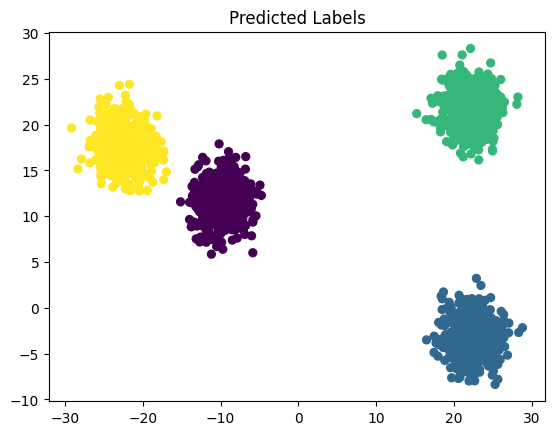

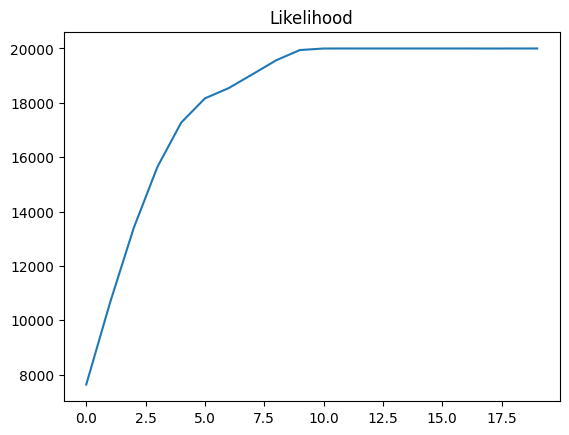

In [8]:
N_STEPS = 20

gibbs_lda = GibbsLDA(N_TOPICS).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, gibbs_lda.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(gibbs_lda.likelihood_log_, 'Likelihood')

#### Gibbs SLDA

100%|██████████| 20/20 [00:01<00:00, 13.46it/s]


Score: 0.999


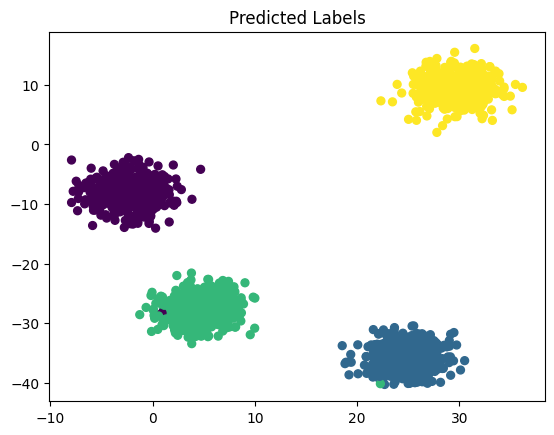

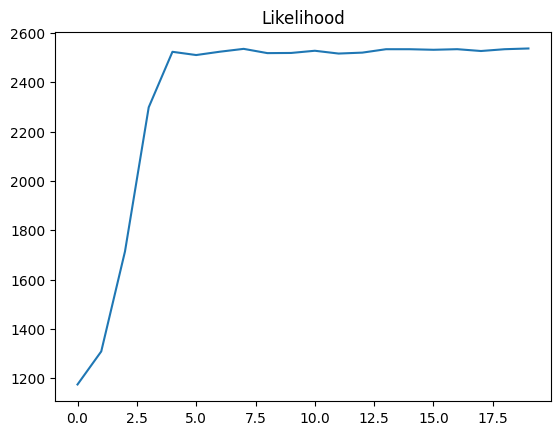

In [19]:
N_STEPS = 20

model = GibbsSLDA(N_TOPICS)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
util.visualize_data(X, labels, 'Predicted Labels')
util.visualize_log(model.likelihood_log_, 'Likelihood')

## Spine Data

In [2]:
import muon as mu
import numpy as np
from sklearn.neighbors import NearestNeighbors

def remove_lonely(data, labels, threshold=225., n_neighbors=12):
    locs = data[:, :2]
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(locs)
    max_dist = knn.kneighbors()[0].max(-1)
    remove_idx, = np.where(max_dist > threshold)
    data = np.delete(data, remove_idx, axis=0)
    labels = np.delete(labels, remove_idx, axis=0)
    return data, labels

def read_spine_data(filename, threshold=225., n_neighbors=12, feature_key='protein', id_key='protein:celltype'):
    mdata = mu.read(filename)
    x, y = mdata['physical'].obsm['spatial'].T
    features = mdata[feature_key].X
    data = np.concatenate([x[None].T, y[None].T, features], -1)
    ids = mdata.obs[id_key]
    labels = np.unique(ids, return_inverse=True)[1]
    if threshold is not None:
        data, labels = remove_lonely(data, labels, threshold, n_neighbors)
    return data, labels

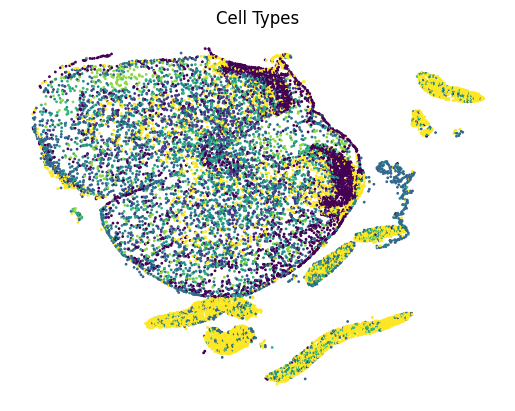

In [22]:
X, X_labels = read_spine_data('data/m387ntga2.h5mu')
clear_output()
util.visualize_data(X, X_labels, 'Cell Types', size=1, show_ax=False)

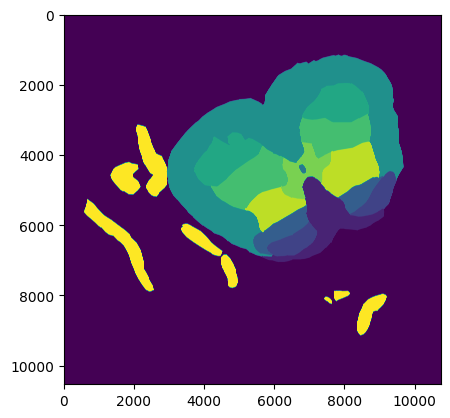

In [23]:
from skimage import io
import matplotlib.pyplot as plt

img = io.imread('data/m387ntga2.tiff').astype(np.int32)
plt.imshow(img);

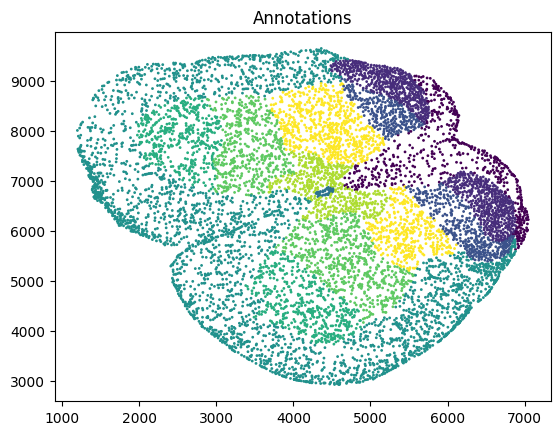

In [24]:
from scipy import ndimage
from skimage.segmentation import watershed

distance = ndimage.distance_transform_edt(img)
labels = watershed(-distance, 2, mask=img)
X_labels = np.zeros_like(X_labels)
for i in range(X_labels.shape[0]):
    x, y = int(X[i, 0]), int(X[i, 1])
    val = labels[x, y]
    if val > 0:
        X_labels[i] = img[x, y]
X = np.delete(X, np.where(X_labels == 0), 0)
X_labels = np.delete(X_labels, np.where(X_labels == 0), 0)
util.visualize_data(X, X_labels, 'Annotations', size=1)

#### Gibbs LDA

100%|██████████| 100/100 [05:07<00:00,  3.08s/it]

Score: 0.2867838910947249


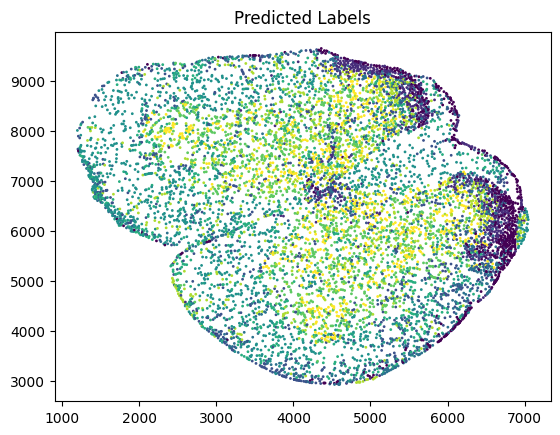

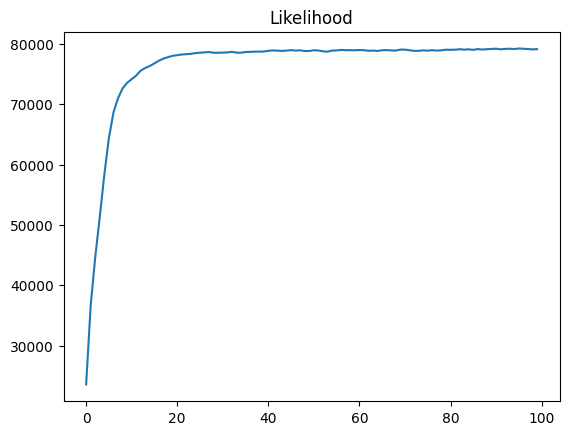

In [12]:
N_STEPS = 100

n_topics = np.unique(X_labels).shape[0]
gibbs_lda = GibbsLDA(n_topics).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, gibbs_lda.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels', size=1)
util.visualize_log(gibbs_lda.likelihood_log_, 'Likelihood')

#### Gibbs SLDA

100%|██████████| 500/500 [02:40<00:00,  3.11it/s]

Score: 0.4015882019285309


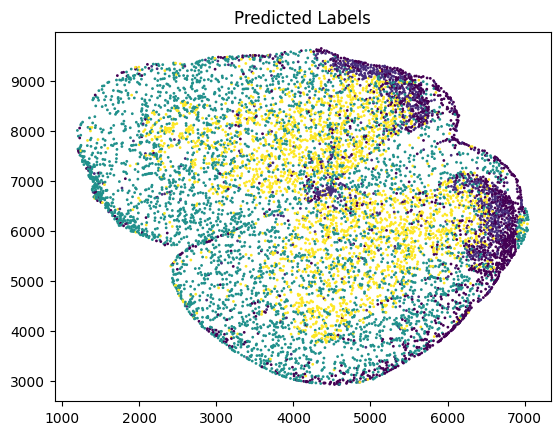

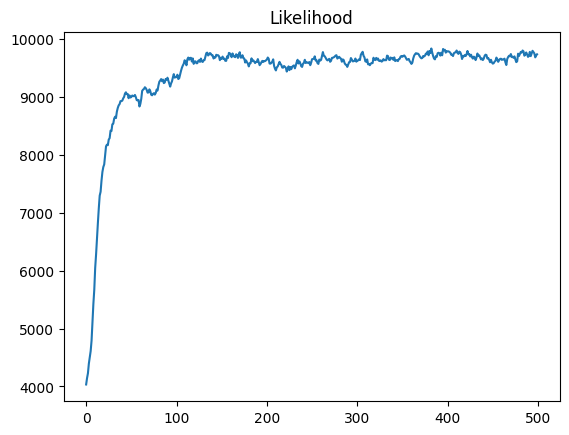

In [27]:
N_STEPS = 500

n_topics = 4
model = GibbsSLDA(n_topics)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels', size=1)
util.visualize_log(model.likelihood_log_, 'Likelihood')